In [246]:
from tensorflow import keras
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Input
from tensorflow.keras.callbacks import EarlyStopping
from sklearn import metrics
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

### Preprocessing the data

#### Cutting the dataset so that there is the same amount of fraud and not fraud cases

In [247]:
df = pd.read_csv('../data/card_transdata.csv')

df = df.dropna()

fraud_count = df['fraud'].value_counts()
min_count = fraud_count.min()

fraud_df = df[df['fraud'] == 1].sample(n=5000, random_state=42)
non_fraud_df = df[df['fraud'] == 0].sample(n=5000, random_state=42)

df = pd.concat([fraud_df, non_fraud_df])
df = df.sample(frac=1, random_state=42).reset_index(drop=True)

#### Separating input and target data and using standar scaling on the continuous values

In [248]:
X = df.drop(columns=["fraud"])
y = df["fraud"]

binary_columns = [col for col in X.columns if set(X[col].unique()) <= {0, 1}]
continuous_columns = [col for col in X.columns if col not in binary_columns]

scaler = StandardScaler()
X_scaled_continuous = scaler.fit_transform(df[continuous_columns])

X_scaled = pd.concat(
    [pd.DataFrame(X_scaled_continuous, columns=continuous_columns), X[binary_columns].reset_index(drop=True)],
    axis=1
)

y = keras.utils.to_categorical(y)

X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.3, random_state=42, stratify=y)

print(X_scaled.shape)
print(y.shape)

(10000, 7)
(10000, 2)


### Plotting visualizations fo the input data

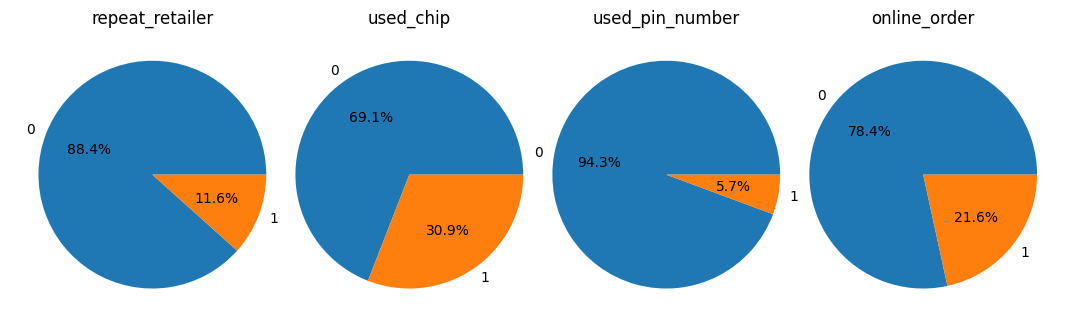

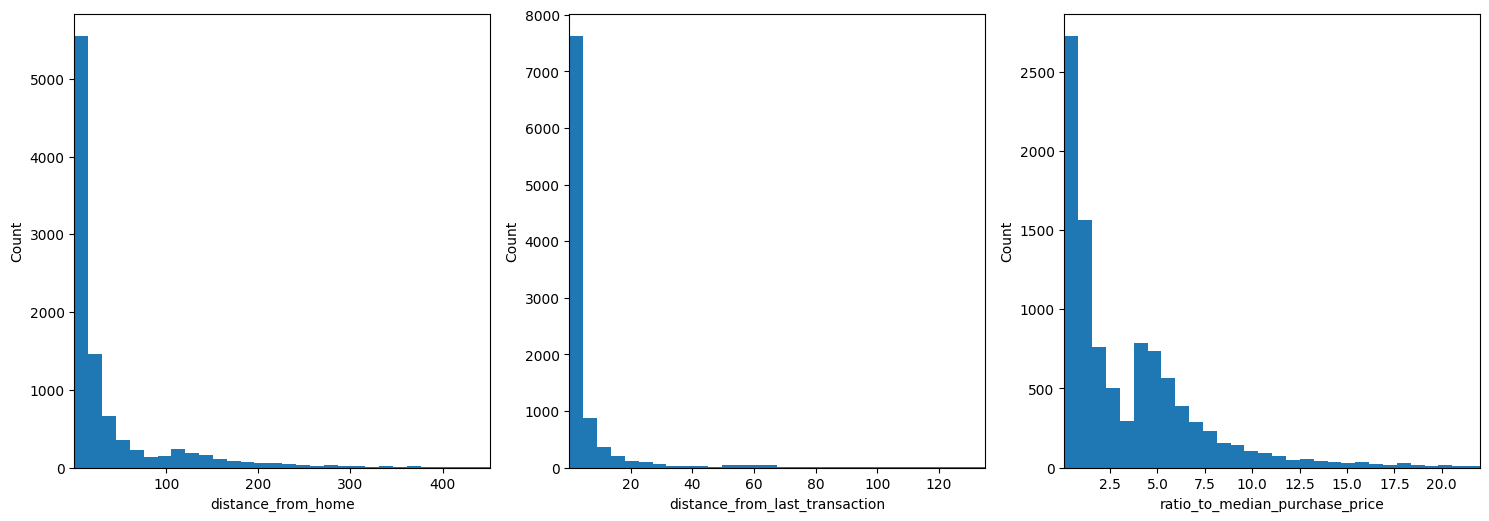

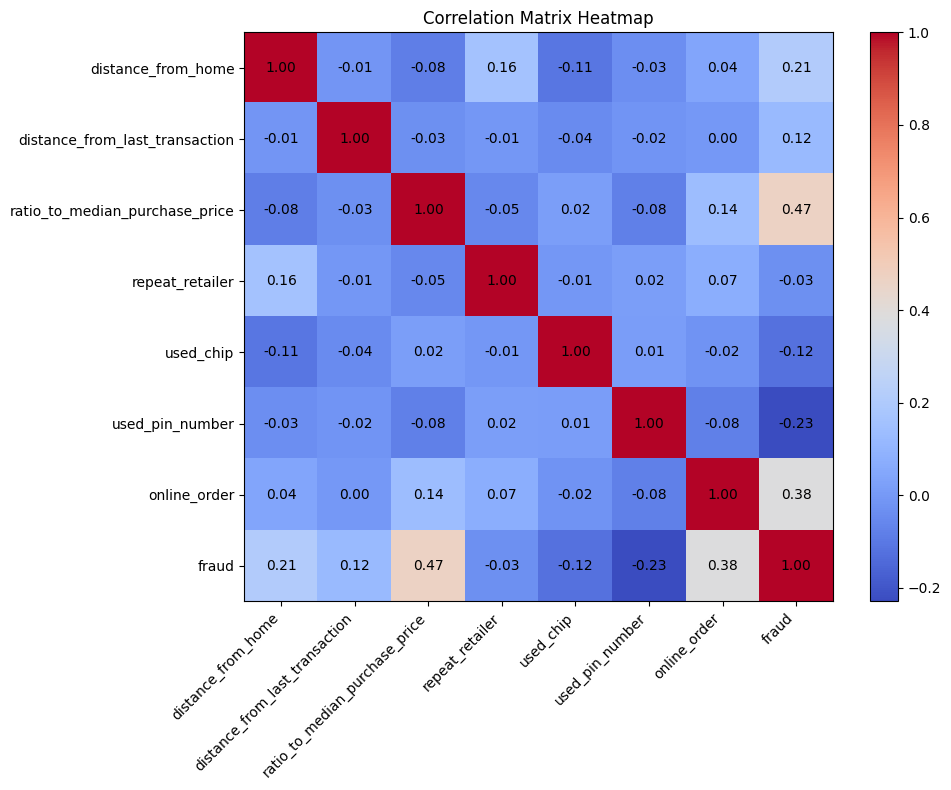

In [249]:
# Plot binary features
plt.figure(figsize=(10, 5))
for i, column in enumerate(binary_columns, 1):
    plt.subplot(1, len(binary_columns), i)
    values = df[column].value_counts()
    plt.pie(values, labels=['0', '1'], autopct='%1.1f%%')
    plt.title(column)
plt.tight_layout(pad=-2)
plt.show()

# Plot continuous features
plt.figure(figsize=(15, 10))
for i, column in enumerate(continuous_columns, 1):
    plt.subplot(2, 3, i)
    q1, q99 = np.percentile(df[column], [1, 99])
    filtered_data = df[column][(df[column] >= q1) & (df[column] <= q99)]
    plt.hist(filtered_data, bins=30)
    plt.xlabel(column)
    plt.ylabel('Count')
    plt.xlim(q1, q99)
plt.tight_layout()
plt.show()

# Correlation Matrix
plt.figure(figsize=(10, 8))
correlation_matrix = df.corr()
plt.imshow(correlation_matrix, cmap='coolwarm', aspect='auto')
plt.colorbar()
plt.xticks(range(len(correlation_matrix.columns)), correlation_matrix.columns, rotation=45, ha='right')
plt.yticks(range(len(correlation_matrix.columns)), correlation_matrix.columns)
for i in range(len(correlation_matrix.columns)):
    for j in range(len(correlation_matrix.columns)):
        plt.text(j, i, f'{correlation_matrix.iloc[i, j]:.2f}', 
                ha='center', va='center')
plt.title('Correlation Matrix Heatmap')
plt.tight_layout()
plt.show()

### Applying PCA to the data

In [250]:
# Apply PCA preprocessing
from sklearn.decomposition import PCA

def apply_pca(X_train_scaled, X_test_scaled):
    # Keep 95% of the variance
    pca = PCA(n_components=0.95)
    X_train_pca = pca.fit_transform(X_train_scaled)
    X_test_pca = pca.transform(X_test_scaled)

    print("Original number of features:", X_train.shape[1])
    print("Number of features after PCA:", X_train_pca.shape[1])
    print("Explained variance ratio: {:.2f}".format(sum(pca.explained_variance_ratio_)))

    return X_train_pca, X_test_pca

### Applying t-SNE to the data

In [251]:
# Apply t-SNE preprocessing
from sklearn.manifold import TSNE

def apply_tsne(X_train_scaled, X_test_scaled):
    tsne = TSNE(n_components=2, random_state=42)
    X_train_tsne = tsne.fit_transform(X_train_scaled)
    X_test_tsne = tsne.fit_transform(X_test_scaled)

    print("Original number of features:", X_train.shape[1])
    print("Number of features after t-SNE:", X_train_tsne.shape[1])

    plt.figure(figsize=(10, 8))
    y_train_plot = np.argmax(y_train, axis=1)
    plt.scatter(X_train_tsne[:, 0], X_train_tsne[:, 1], c=y_train_plot, cmap='viridis')
    plt.colorbar()
    plt.title('t-SNE visualization of the training data')
    plt.xlabel('t-SNE feature 1')
    plt.ylabel('t-SNE feature 2')
    plt.show()

    return X_train_tsne, X_test_tsne

### Creating the model

#### Function to create the model

In [252]:
def create_model(
        X_train, # training data
        y_train, # training labels
        X_test, # testing data
        learning_rate=0.001, # learning rate
        validation_split=0.33, # validation split
        epochs=50, # number of epochs
        batch_size=64, # batch size
        patience=3, # patience for early stopping
        loss_function='mean_squared_error', # loss function
        optimizer='adam', # optimizer
        early_stopping=True, # early stopping
        use_pca=False, # use PCA
        use_tsne=False # use t-SNE
):

    if use_pca:
        X_train, X_test = apply_pca(X_train, X_test)
    if use_tsne:
        X_train, X_test = apply_tsne(X_train, X_test)

    #initializing the model and adding the hidden layers
    model = Sequential()
    model.add(Input(shape=(X_train.shape[1],)))
    model.add(Dense(64, activation='relu')) # Hidden layer
    model.add(Dense(y.shape[1], activation='softmax')) # Output layer

    if optimizer == 'adam':
        opt = keras.optimizers.Adam(learning_rate=learning_rate)
    elif optimizer == 'sgd':
        opt = keras.optimizers.SGD(learning_rate=learning_rate)
    elif optimizer == 'rmsprop':
        opt = keras.optimizers.RMSprop(learning_rate=learning_rate)

    model.compile(loss=loss_function, optimizer=opt, metrics=['accuracy'])

    # Adding early stopping with patience of 3
    monitor = EarlyStopping(
        monitor='loss',
        min_delta=1e-3,
        patience=patience,
        verbose=1,
        mode='auto', 
        restore_best_weights=True
    )

    # training the model and saving the result to plot later
    result = model.fit(
        X_train,
        y_train,
        validation_split=validation_split,
        verbose=1,
        epochs=epochs,
        batch_size=batch_size,
        callbacks=[monitor] if early_stopping else [],
    )

    return model, result, X_test

#### Function to plot the results

In [253]:
def plot_results(result, y_compare, pred):
    # Loss and accuracy curves for training and validation
    plt.figure(figsize=(10, 8))
    plt.plot(result.history['loss'])
    plt.plot(result.history['val_loss'])
    plt.title('model loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['training', 'validation'], loc='upper left')
    plt.show()

    plt.figure(figsize=(10, 8))
    plt.plot(result.history['accuracy'])
    plt.plot(result.history['val_accuracy'])
    plt.title('Model Accuracy')
    plt.ylabel('Accuracy')
    plt.xlabel('Epoch')
    plt.legend(['Training', 'Validation'], loc='upper left')
    plt.show()

    # Getting relevant scores values for accuracy, precision, recall, F1 and R2
    score = metrics.accuracy_score(y_compare, pred)
    precision = metrics.precision_score(y_compare, pred)
    recall = metrics.recall_score(y_compare, pred)
    f1 = metrics.f1_score(y_compare, pred)
    r2 = metrics.r2_score(y_compare, pred)
    rmse = np.sqrt(metrics.mean_squared_error(pred,y_compare))

    print("Accuracy score: {:.2f}".format(score))
    print("Precision score: {:.2f}".format(precision))
    print("Recall score: {:.2f}".format(recall))
    print("F1 score: {:.2f}".format(f1))
    print("R2 score: {:.2f}".format(r2))
    print("Mean Square Error: {:.2f}".format(rmse))


    #confusion matrix
    labels = ['Not Fraud', 'Fraud']

    plt.figure(figsize=(10, 8))
    confusion_mtx = metrics.confusion_matrix(y_compare, pred)
    plt.imshow(confusion_mtx, interpolation='nearest', cmap='Blues')
    plt.colorbar()

    plt.title('Confusion Matrix')
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')

    for i in range(confusion_mtx.shape[0]):
        for j in range(confusion_mtx.shape[1]):
            plt.text(j, i, str(confusion_mtx[i, j]),
                    ha='center', va='center')

    plt.xticks([0, 1], labels)
    plt.yticks([0, 1], labels)

    plt.tight_layout()
    plt.show()

#### Instantiating the model and testing it with different parameters

In [254]:
#adam optimizer with no PCA or t-SNE and learning rate of 0.001

model1, result1, X_test_1 = create_model(
    X_train,
    y_train,
    X_test,
    learning_rate=0.001,
    validation_split=0.33,
    epochs=50,
    batch_size=64,
    patience=3,
    loss_function='mean_squared_error',
    optimizer='adam',
    early_stopping=True
)

pred1 = model1.predict(X_test_1)

pred1 = np.argmax(pred1, axis=1)
y_compare1 = np.argmax(y_test, axis=1)

Epoch 1/50
74/74 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.6420 - loss: 0.2489 - val_accuracy: 0.9446 - val_loss: 0.1273
Epoch 2/50
74/74 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9557 - loss: 0.1107 - val_accuracy: 0.9602 - val_loss: 0.0752
Epoch 3/50
74/74 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9612 - loss: 0.0678 - val_accuracy: 0.9572 - val_loss: 0.0570
Epoch 4/50
74/74 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9590 - loss: 0.0532 - val_accuracy: 0.9598 - val_loss: 0.0487
Epoch 5/50
74/74 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9674 - loss: 0.0417 - val_accuracy: 0.9611 - val_loss: 0.0438
Epoch 6/50
74/74 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9652 - loss: 0.0408 - val_accuracy: 0.9645 - val_loss: 0.0406
Epoch 7/50
74/74 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9620 - loss: 0.0375 - val_accuracy: 0.9658 - val_loss: 0.0381
Epoch 8/50
74/74 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9704 - loss: 0.0335 - val_accuracy: 0.9671 - val_loss:

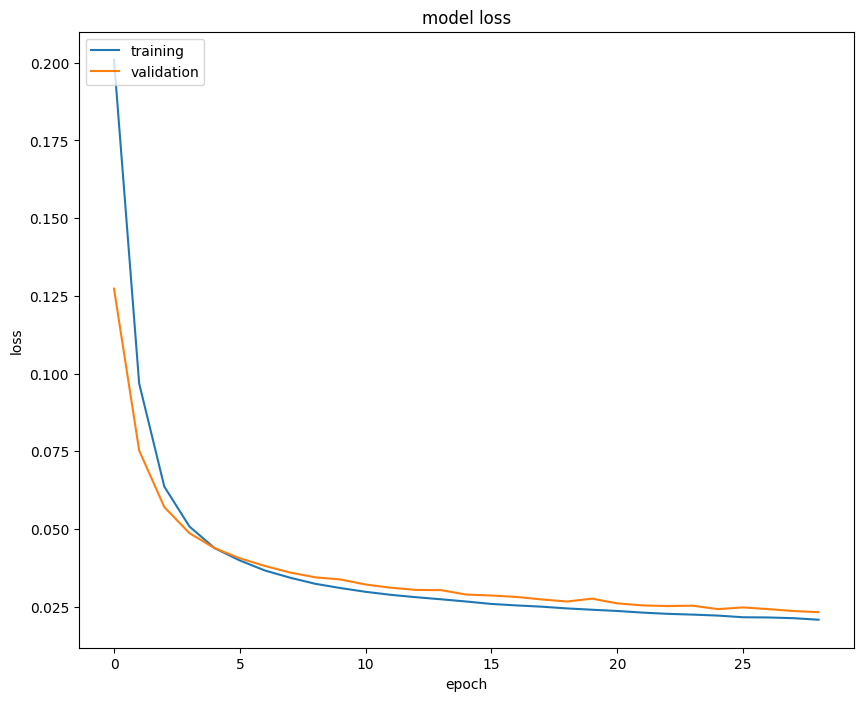

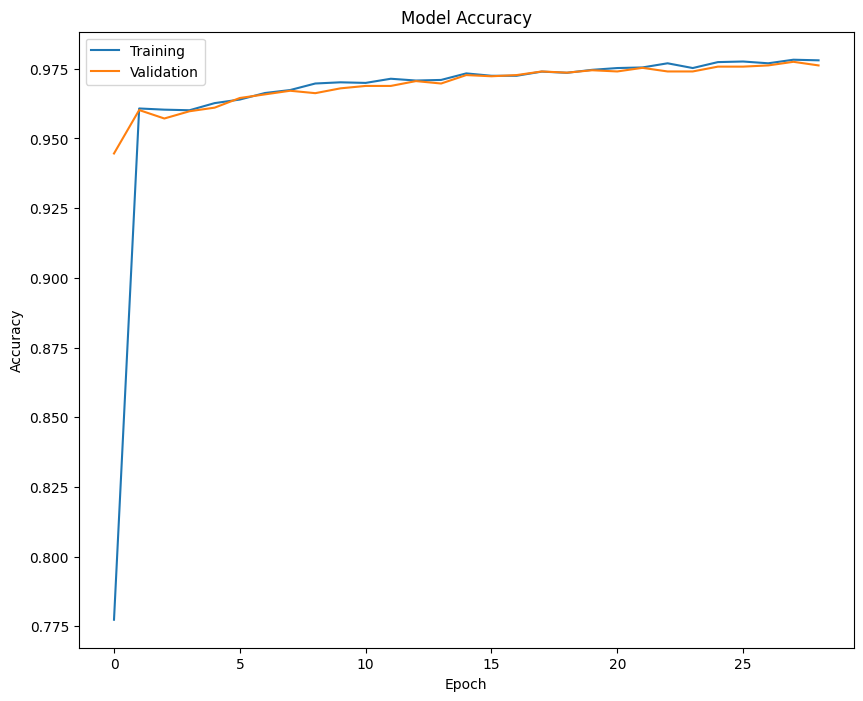

Accuracy score: 0.98
Precision score: 0.97
Recall score: 0.99
F1 score: 0.98
R2 score: 0.91
Mean Square Error: 0.15


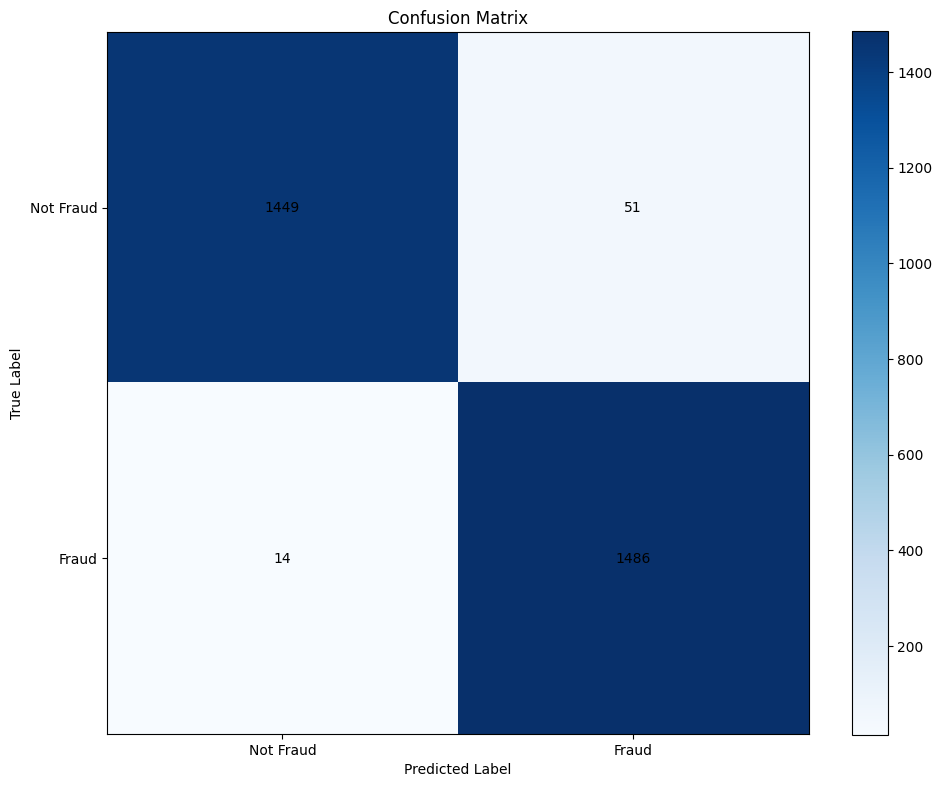

In [255]:
plot_results(result1, y_compare1, pred1)

In [256]:
#sgd optimizer with no PCA or t-SNE and learning rate of 0.001

model2, result2, X_test_2 = create_model(
    X_train,
    y_train,
    X_test,
    learning_rate=0.001,
    validation_split=0.33,
    epochs=50,
    batch_size=64,
    patience=3,
    loss_function='mean_squared_error',
    optimizer='sgd',
    early_stopping=True
)

pred2 = model2.predict(X_test_2)

pred2 = np.argmax(pred2, axis=1)
y_compare2 = np.argmax(y_test, axis=1)

Epoch 1/50
74/74 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.4234 - loss: 0.2418 - val_accuracy: 0.4310 - val_loss: 0.2413
Epoch 2/50
74/74 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.4382 - loss: 0.2379 - val_accuracy: 0.4647 - val_loss: 0.2376
Epoch 3/50
74/74 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.4943 - loss: 0.2344 - val_accuracy: 0.5534 - val_loss: 0.2341
Epoch 4/50
74/74 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.5707 - loss: 0.2308 - val_accuracy: 0.6153 - val_loss: 0.2307
Epoch 5/50
74/74 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.6369 - loss: 0.2274 - val_accuracy: 0.6577 - val_loss: 0.2275
Epoch 6/50
74/74 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.6684 - loss: 0.2254 - val_accuracy: 0.6958 - val_loss: 0.2244
Epoch 7/50
74/74 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7081 - loss: 0.2232 - val_accuracy: 0.7270 - val_loss: 0.2215
Epoch 8/50
74/74 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7303 - loss: 0.2192 - val_accuracy: 0.7438 - val_loss:

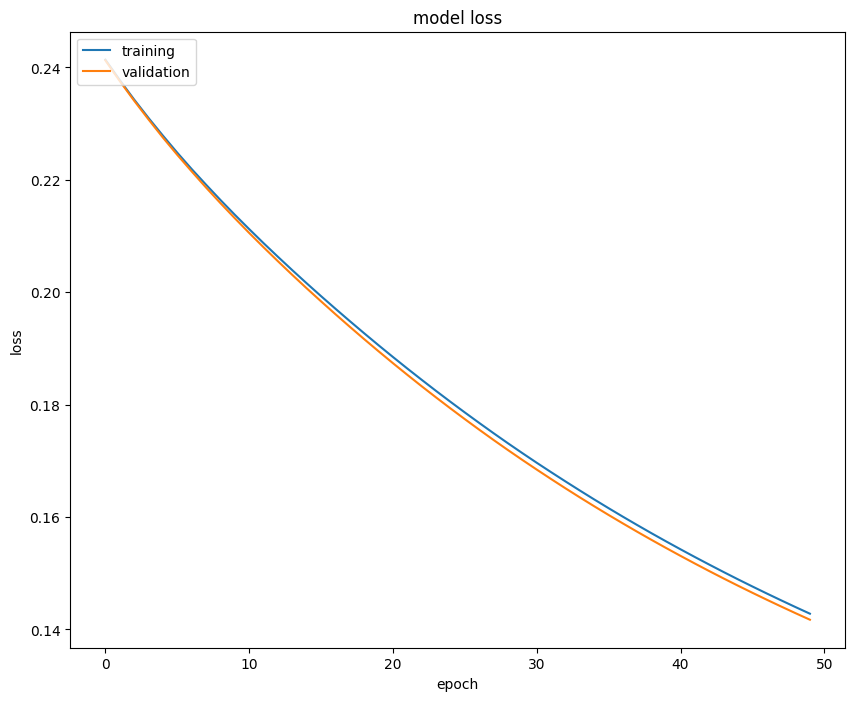

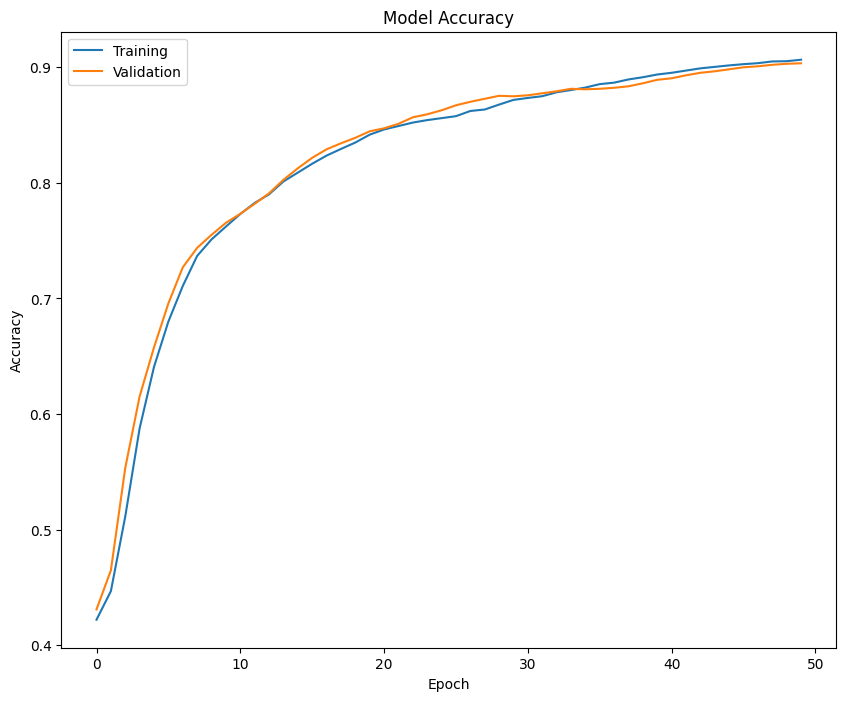

Accuracy score: 0.91
Precision score: 0.93
Recall score: 0.90
F1 score: 0.91
R2 score: 0.65
Mean Square Error: 0.29


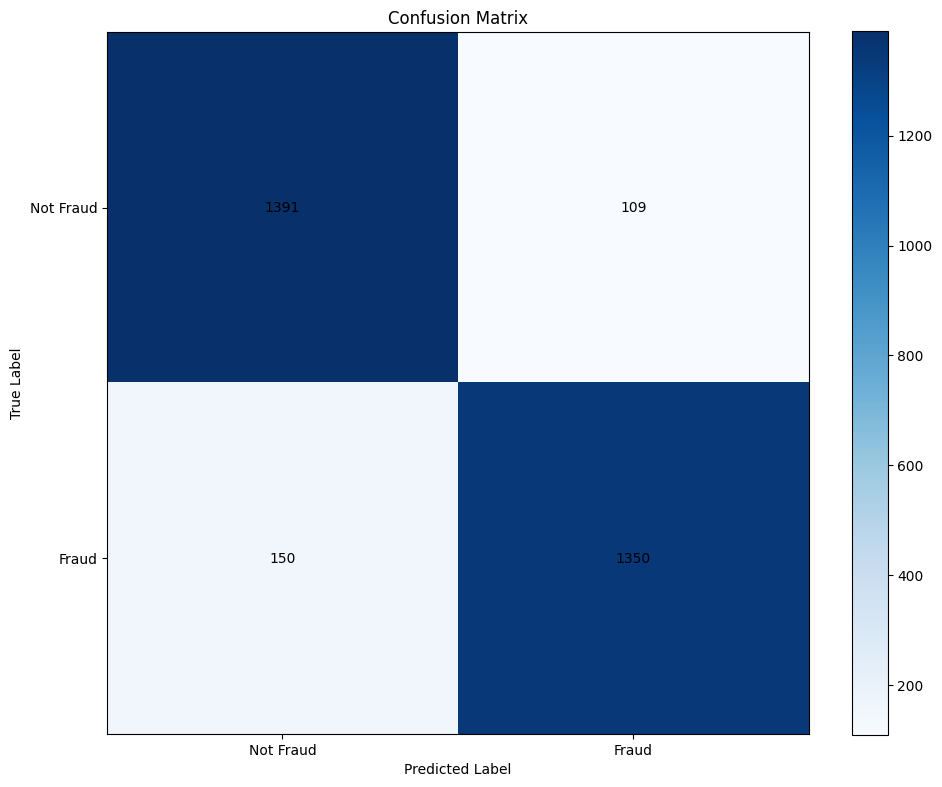

In [257]:
plot_results(result2, y_compare2, pred2)

In [258]:
#rmsprop optimizer with no PCA or t-SNE and learning rate of 0.001

model3, result3, X_test_3 = create_model(
    X_train,
    y_train,
    X_test,
    learning_rate=0.001,
    validation_split=0.33,
    epochs=50,
    batch_size=64,
    patience=3,
    loss_function='mean_squared_error',
    optimizer='rmsprop',
    early_stopping=True
)

pred3 = model3.predict(X_test_3)

pred3 = np.argmax(pred3, axis=1)
y_compare3 = np.argmax(y_test, axis=1)

Epoch 1/50
74/74 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.7861 - loss: 0.1933 - val_accuracy: 0.9299 - val_loss: 0.1021
Epoch 2/50
74/74 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9421 - loss: 0.0904 - val_accuracy: 0.9476 - val_loss: 0.0635
Epoch 3/50
74/74 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9493 - loss: 0.0576 - val_accuracy: 0.9498 - val_loss: 0.0508
Epoch 4/50
74/74 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9518 - loss: 0.0473 - val_accuracy: 0.9537 - val_loss: 0.0451
Epoch 5/50
74/74 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9538 - loss: 0.0430 - val_accuracy: 0.9563 - val_loss: 0.0417
Epoch 6/50
74/74 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9556 - loss: 0.0396 - val_accuracy: 0.9606 - val_loss: 0.0395
Epoch 7/50
74/74 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9610 - loss: 0.0355 - val_accuracy: 0.9624 - val_loss: 0.0378
Epoch 8/50
74/74 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9678 - loss: 0.0334 - val_accuracy: 0.9624 - val_loss:

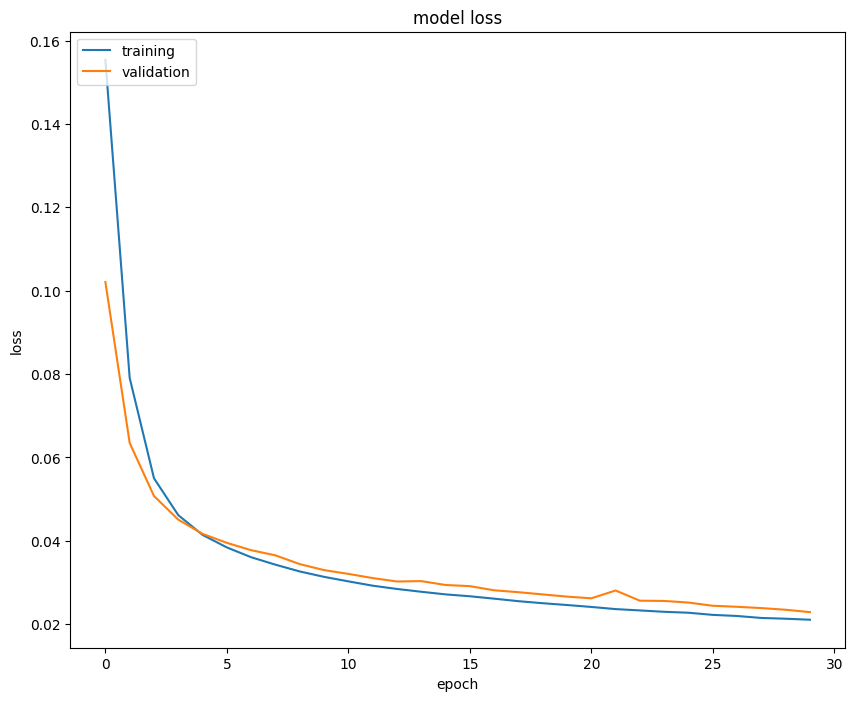

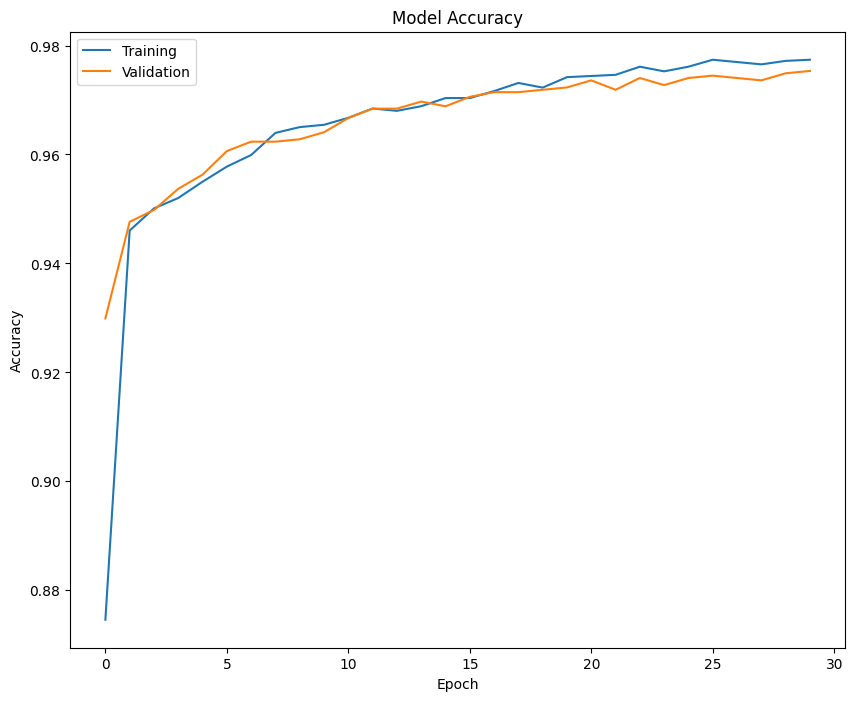

Accuracy score: 0.98
Precision score: 0.96
Recall score: 0.99
F1 score: 0.98
R2 score: 0.90
Mean Square Error: 0.16


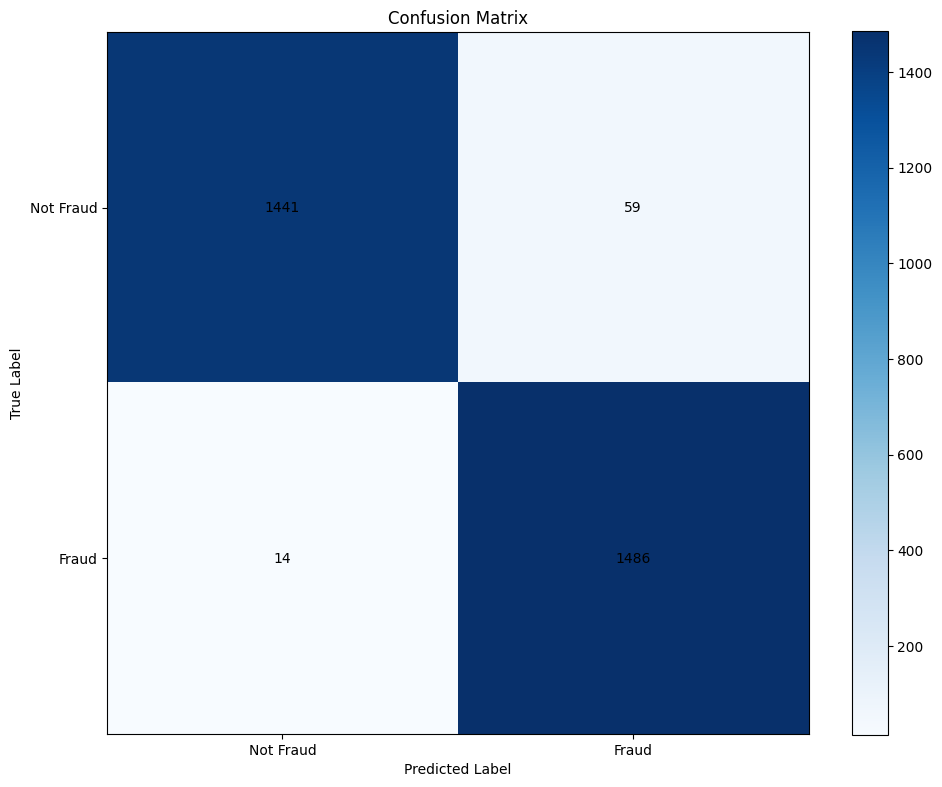

In [259]:
plot_results(result3, y_compare3, pred3)


In [260]:
#adam optimizer with PCA and learning rate of 0.001

model4, result4, X_test = create_model(
    X_train,
    y_train,
    X_test,
    learning_rate=0.001,
    validation_split=0.33,
    epochs=50,
    batch_size=64,
    patience=3,
    loss_function='mean_squared_error',
    optimizer='adam',
    early_stopping=True,
    use_pca=True
)

pred4 = model4.predict(X_test)

pred4 = np.argmax(pred4, axis=1)
y_compare4 = np.argmax(y_test, axis=1)

Original number of features: 7
Number of features after PCA: 5
Explained variance ratio: 0.96
Epoch 1/50
74/74 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.6529 - loss: 0.2184 - val_accuracy: 0.9338 - val_loss: 0.1228
Epoch 2/50
74/74 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9406 - loss: 0.1051 - val_accuracy: 0.9472 - val_loss: 0.0748
Epoch 3/50
74/74 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9484 - loss: 0.0697 - val_accuracy: 0.9463 - val_loss: 0.0596
Epoch 4/50
74/74 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9458 - loss: 0.0580 - val_accuracy: 0.9476 - val_loss: 0.0535
Epoch 5/50
74/74 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9488 - loss: 0.0528 - val_accuracy: 0.9476 - val_loss: 0.0502
Epoch 6/50
74/74 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9524 - loss: 0.0462 - val_accuracy: 0.9481 - val_loss: 0.0479
Epoch 7/50
74/74 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9516 - loss: 0.0450 - val_accuracy: 0.9489 - val_loss: 0.0462
Epoch 8/50
74/74 ━━━━━━━

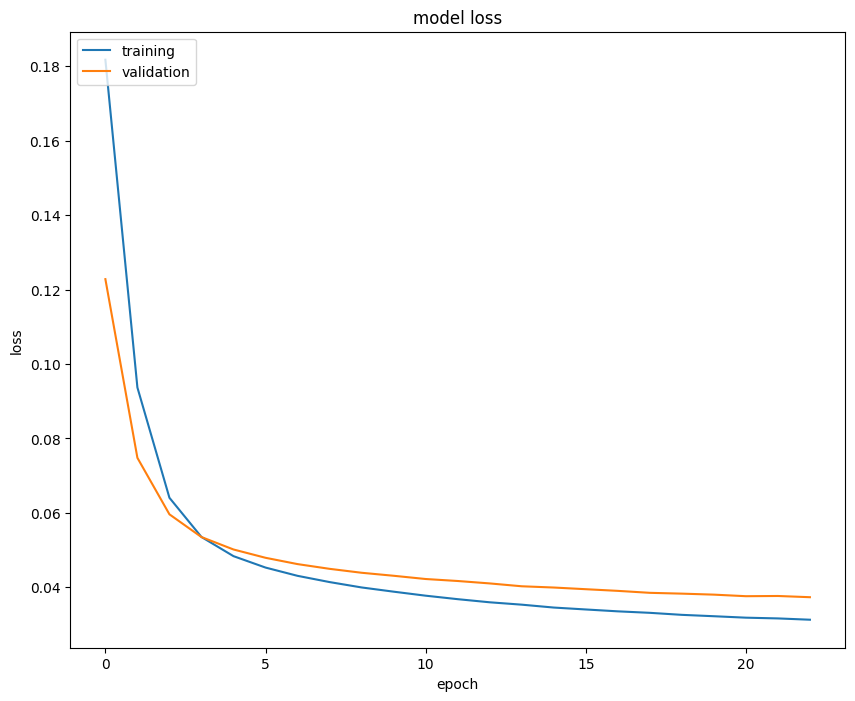

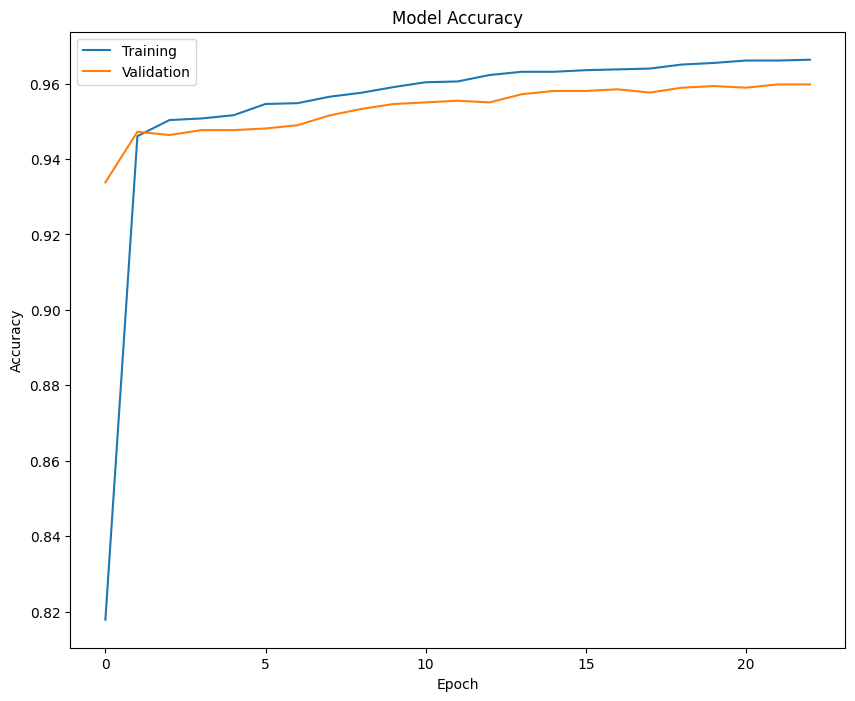

Accuracy score: 0.96
Precision score: 0.94
Recall score: 0.98
F1 score: 0.96
R2 score: 0.84
Mean Square Error: 0.20


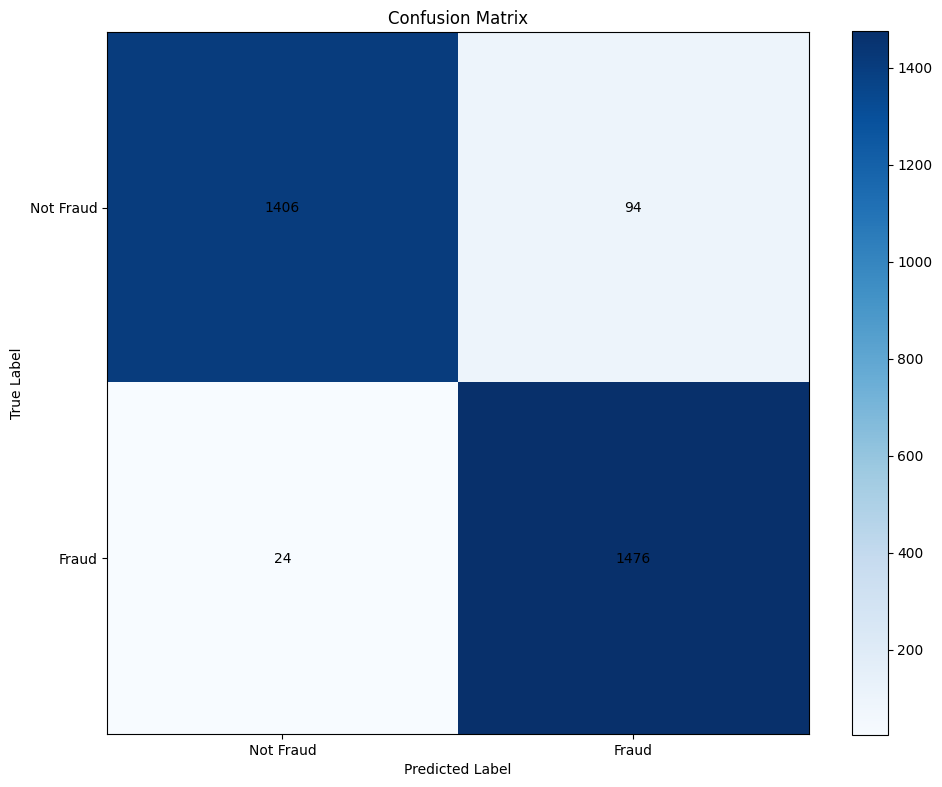

In [261]:
plot_results(result4, y_compare4, pred4)


Original number of features: 7
Number of features after t-SNE: 2


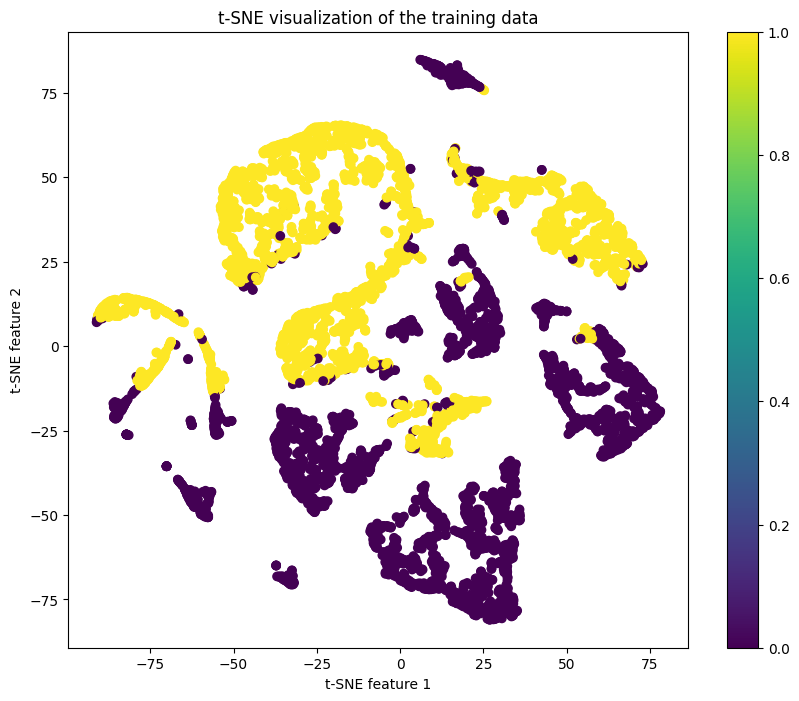

Epoch 1/50
74/74 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.7956 - loss: 0.1620 - val_accuracy: 0.8429 - val_loss: 0.1224
Epoch 2/50
74/74 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8520 - loss: 0.1215 - val_accuracy: 0.8585 - val_loss: 0.1075
Epoch 3/50
74/74 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8645 - loss: 0.1051 - val_accuracy: 0.8520 - val_loss: 0.1020
Epoch 4/50
74/74 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8704 - loss: 0.0967 - val_accuracy: 0.8689 - val_loss: 0.0938
Epoch 5/50
74/74 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8862 - loss: 0.0851 - val_accuracy: 0.8836 - val_loss: 0.0873
Epoch 6/50
74/74 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8767 - loss: 0.0894 - val_accuracy: 0.8810 - val_loss: 0.0856
Epoch 7/50
74/74 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8978 - loss: 0.0839 - val_accuracy: 0.9018 - val_loss: 0.0804
Epoch 8/50
74/74 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8899 - loss: 0.0843 - val_accuracy: 0.9070 - val_loss:

In [262]:
#adam optimizer with t-SNE and learning rate of 0.001

model5, result5, X_test_5 = create_model(
    X_train,
    y_train,
    X_test,
    learning_rate=0.001,
    validation_split=0.33,
    epochs=50,
    batch_size=64,
    patience=3,
    loss_function='mean_squared_error',
    optimizer='adam',
    early_stopping=True,
    use_tsne=True
)

pred5 = model5.predict(X_test_5)

pred5 = np.argmax(pred5, axis=1)
y_compare5 = np.argmax(y_test, axis=1)

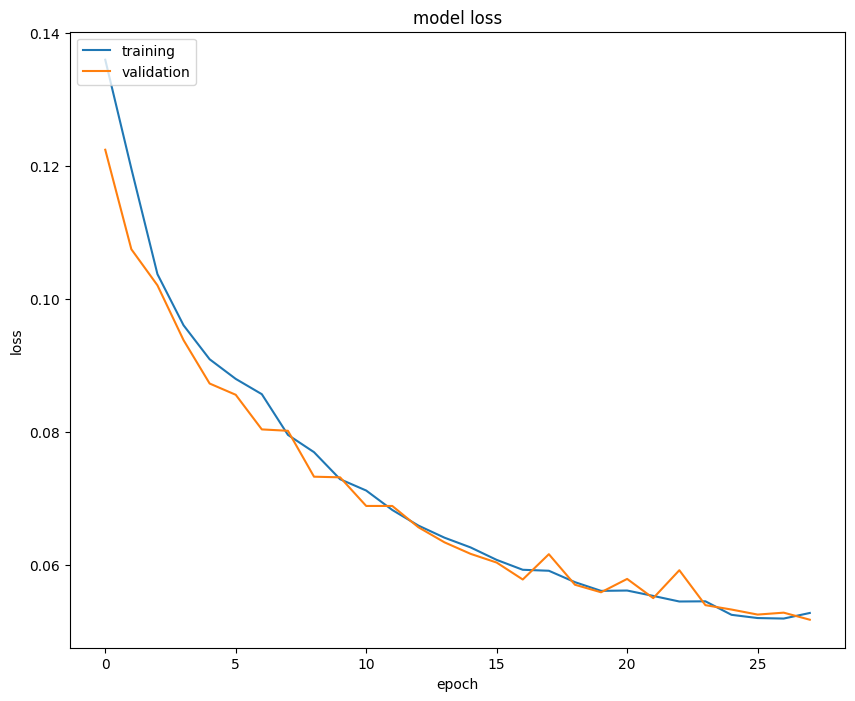

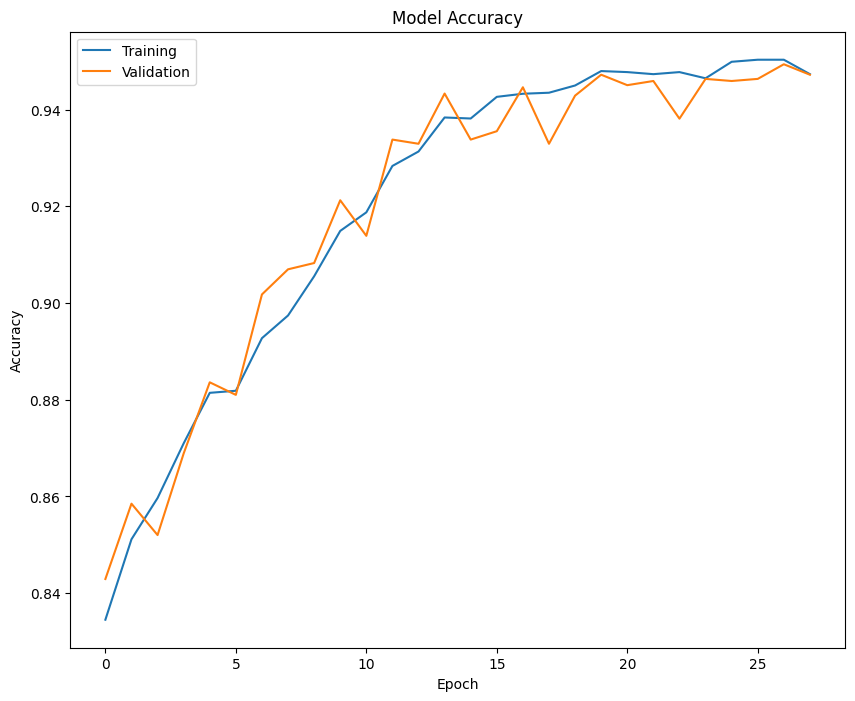

Accuracy score: 0.39
Precision score: 0.40
Recall score: 0.44
F1 score: 0.42
R2 score: -1.44
Mean Square Error: 0.78


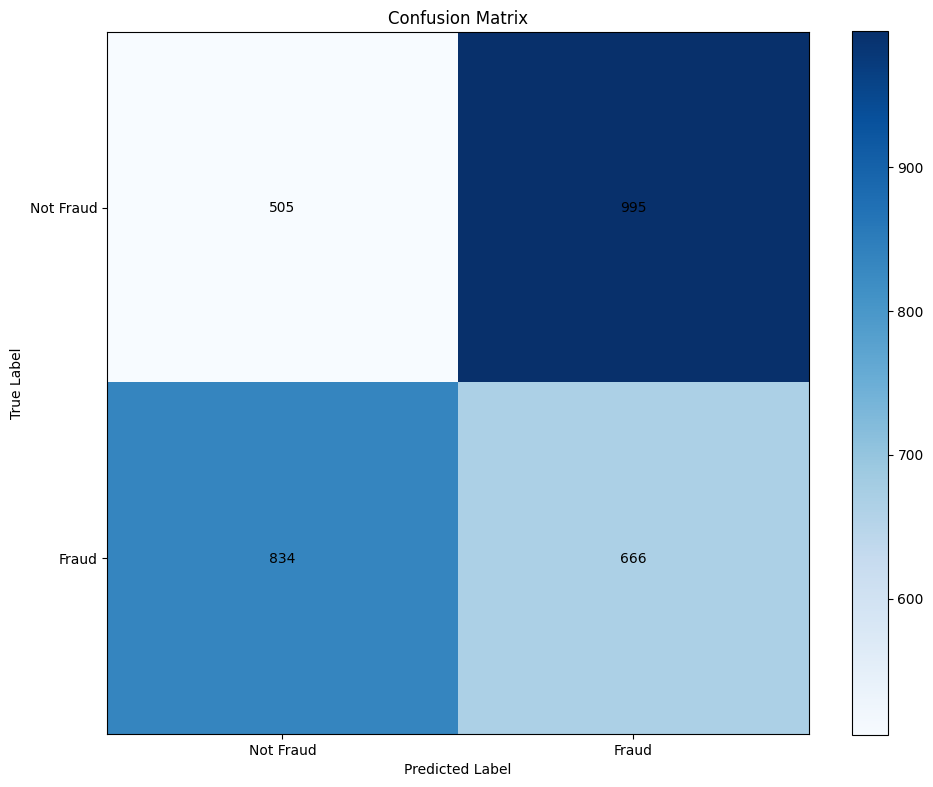

In [263]:
plot_results(result5, y_compare5, pred5)